In [1]:
import pandas as pd, numpy as np
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import GridSearchCV

import sklearn
from sklearn_pandas import DataFrameMapper

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt

Using TensorFlow backend.


Get the data from s3.

In [5]:
!wget https://s3.amazonaws.com/rorodata-datasets/lending-club-data.csv -O /volumes/data/lending-club-data.csv

--2017-09-13 11:44:57--  https://s3.amazonaws.com/rorodata-datasets/lending-club-data.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.81.139
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.81.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73529037 (70M) [binary/octet-stream]
Saving to: ‘/volumes/data/lending-club-data.csv’

/volumes/data/lendi 100%[=====================>]  70.12M  97.6MB/s   in 0.7s   

2017-09-13 11:44:58 (97.6 MB/s) - ‘/volumes/data/lending-club-data.csv’ saved [73529037/73529037]



In [6]:
def getDate(s):
    s=str(s)[0:8]
    retval=None
    try:
        retval=datetime.datetime.strptime(s, "%Y%m%d")
    except:
        pass
        #print s
        
    return retval

In [7]:
IN_DATAFILE='/volumes/data/lending-club-data.csv'
loans = pd.read_csv(IN_DATAFILE, infer_datetime_format = True)

# loans['final_date']=loans['final_d'].apply(getDate)

# loans['outcome']=(loans['final_date'] < datetime.datetime(2015, 3, 31))


# completed_loans=loans[(loans['outcome']==1) & (loans["inactive_loans"]==1)]
# completed_loans.shape

features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies 
            'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
           ]
response='bad_loans'

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
#clean_data=completed_loans[features+[response]].dropna()
clean_data=loans[features+[response]].dropna()


numerical_cols=['sub_grade_num', 'short_emp', 'emp_length_num','dti', 'payment_inc_ratio', 'delinq_2yrs', \
                'delinq_2yrs_zero', 'inq_last_6mths', 'last_delinq_none', 'last_major_derog_none', 'open_acc',\
                'pub_rec', 'pub_rec_zero','revol_util']

categorical_cols=['grade', 'home_ownership', 'purpose']

mapper = DataFrameMapper([
('grade',sklearn.preprocessing.LabelBinarizer()),
('home_ownership', sklearn.preprocessing.LabelBinarizer()),
('purpose', sklearn.preprocessing.LabelBinarizer()),
        
    ])

X1=mapper.fit_transform(clean_data)


X2=np.array(clean_data[numerical_cols])


X = np.hstack((X1,X2)) #Combines X1 and X2 side by side, i.e. stacks them horizontally
y=np.array(clean_data['bad_loans'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=100, stratify=y)

In [10]:
log_lm = LogisticRegression()
log_lm.fit(X_train, y_train)
log_lm.score(X_test, y_test)

0.81184643148500657

In [11]:
y_pred = log_lm.predict_proba(X_test)[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred)

In [12]:
grd = GradientBoostingClassifier(n_estimators=100)
grd.fit(X_train, y_train)
grd.score(X_test, y_test)

0.81142616993399419

In [13]:
%%time
dtree=DecisionTreeClassifier()
parameters = {'max_depth':[5, 10, 15, 20, 25, 32]}
dtree_gs = GridSearchCV(dtree, parameters, cv=5)
dtree_gs.fit(X_train, y_train)
print(dtree_gs.score(X_test, y_test))

0.810412597958
CPU times: user 17.5 s, sys: 0 ns, total: 17.5 s
Wall time: 17.5 s


In [14]:
%%time
rf=RandomForestClassifier()
parameters = {'max_depth':[5, 15], 'n_estimators':[10,30]}
rf_gs = GridSearchCV(rf, parameters)
rf_gs.fit(X_train, y_train)
print(rf_gs.score(X_test, y_test))

0.811178957257
CPU times: user 13.2 s, sys: 4 ms, total: 13.2 s
Wall time: 13.2 s


In [15]:
a={ 'delinq_2yrs': 0.0,
 'delinq_2yrs_zero': 1.0,
 'dti': 8.7200000000000006,
 'emp_length_num': 0,
 'grade': 'F',
 'home_ownership': 'RENT',
 'inq_last_6mths': 3.0,
 'last_delinq_none': 1,
 'last_major_derog_none': 1,
 'open_acc': 2.0,
 'payment_inc_ratio': 4.5,
 'pub_rec': 0.0,
 'pub_rec_zero': 1.0,
 'purpose': 'vacation',
 'revol_util': 98.5,
 'short_emp': 0,
 'sub_grade_num': 1.0}

In [20]:
def preProcess(a):
    data=list(a.values())
    colz=list(a.keys())
    dfx=pd.DataFrame(data=[data], columns=colz)
    dfx

    XX1=mapper.transform(dfx)
    XX2=dfx[numerical_cols]
    XX = np.hstack((XX1,XX2))
    return XX

def predictProb_LogisticReg(XX, model):
    try:
        return model.predict_proba(XX)[:,1][0]
    except:
        return -1
    
def predictProb_GBoost(XX, model):
    try:
        return model.predict_proba(XX)[:,1][0]
    except:
        return -1
    
def evaluateApplication(appl, log_lm, grd, dtree_model):
    XX=preProcess(appl) 
    
    results={}
    results['Logistic_Regression']=predictProb_LogisticReg(XX, log_lm)
    results['Gradient_Boosting']=predictProb_GBoost(XX, grd)
    return results

In [21]:
evaluateApplication(a, log_lm, grd, dtree_gs)

{'Gradient_Boosting': 0.53439917441066676,
 'Logistic_Regression': 0.48829986303342249}

In [23]:
y_pred_l= log_lm.predict_proba(X_test)[:,1]
y_pred_g= grd.predict_proba(X_test)[:,1]
y_pred_dt=dtree_gs.predict_proba(X_test)[:,1]
y_pred_rf=rf_gs.predict_proba(X_test)[:,1]
fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_l)
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_g)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

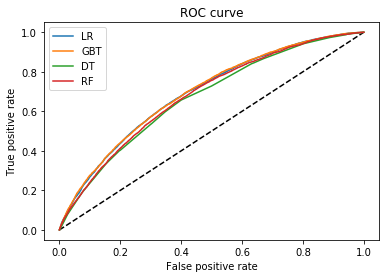

In [24]:
%matplotlib inline
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_log, tpr_log, label='LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_dt, tpr_dt, label='DT')
plt.plot(fpr_rf, tpr_rf, label='RF')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig('temp.jpg')
plt.show()

In [25]:
xa=plt.imread('temp.jpg')


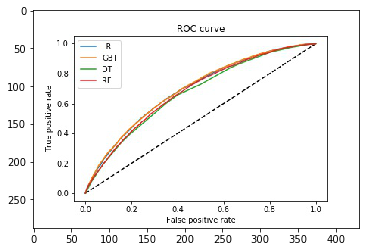

In [26]:
plt.imshow(xa)